## Admixture - visualization
The run is rather straightforward, systematically trying out nr of ancestral populations.
Secondly, based on latitude information, we prepared 5 files of increasing geografic distance from Yemen

Meta data needs to be taken from two files: Reich's anno and Zalloua's meta spreadsheet, only region info is retained from both and then combined.

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [35, 40]
plt.rcParams['svg.fonttype'] = 'none'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_105005/1270030905.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [51]:
!more ../Admixture/Regional/parAdmix_nearby.sh

for distance in 1 2 3 4 5; do
    for K in 2 3 4 5 6 7 8 9 10 12 15; do
	admixture --cv yemen_nearby${distance}K_reichH04.bed $K | tee log_nearby
${distance}_${K}.out &
    done
done


In [2]:
districts = {'Azal': ['Sad', 'Amr', 'San', 'Dhm'], 
             'Tahamh': ['Mhw', 'Haj'], 
             'Hadramaut':['Hdr', 'Shb'], 
             'Aljanad': ['Ibb', 'Tiz'], 
             'Sheba': ['Jwf', 'Mrb', 'Byd'], 
             'Aden': ['Dal', 'Lahj', 'Abyn'], 
             'Hudaydah': ['Rsa']}
revDistricts = {}
for d,reglist in districts.items():
    for reg in reglist:
        revDistricts[reg] = d
        
def lookupPop(id, meta, districtsCombined=False):
    prefix = ''
    if "3577STDY" in id:
        id = id.split('_')[-1]
        prefix = "Yemen/"
    try:
        pop = meta.loc[id]["Region"]
        if districtsCombined and "3577STDY" in id: pop = revDistricts[pop]
    except KeyError:
        print(f"Warning, couldn't find {id} in meta data")
        pop = "???"
    return prefix + pop

### Importing Reich Metadata
Retaining only Region and Group_Label (population)

In [3]:
reichFull=pd.read_csv("../Reich/v44.3_HO_public.anno", sep='\t')
reichFull.columns = ['Index', 'Id', 'Id2',
       'Publication', 'contact',
       'Date',
       'Full_Date',
       'Group_Label', 'Locality', 'Region', 'Lat', 'Long',
       'Data source', 'Cov_autosm',
       'SNPs_autosm', 'Sex',
       'Library_type',
       'ASSESSMENT']

reichMeta = reichFull[['Id','Region','Group_Label']].set_index('Id')

### Importing Zalloua metadata

In [4]:
import re
from collections import Counter
def readZallouaMetadata(manifest, selcols):    
    regionalContext = pd.read_csv(manifest, skiprows=8, sep=',', skip_blank_lines=True)
    regionalContext = regionalContext.iloc[:,selcols]
    regionalContext.columns = 'Id RegionId'.split()
    regionalContext.set_index('Id', inplace=True)
    return regionalContext.dropna(subset=['RegionId'])

yemenMeta = readZallouaMetadata("../Metadata/3577stdy_manifest_3450_190315.csv.gz", [2,3])

## some cleanup
yemenMeta["Region"] = [re.findall('\D+', sup)[0] for sup in yemenMeta['RegionId']]
yemenMeta = yemenMeta[['Region']]
yemenMeta = yemenMeta[yemenMeta.Region!='Empty']
print (Counter(yemenMeta.Region))

Counter({'Rsa': 48, 'Ibb': 25, 'Hdr': 25, 'Tiz': 24, 'Dhm': 10, 'Abyn': 10, 'Sad': 10, 'Mhw': 10, 'Lahj': 10, 'Jwf': 10, 'San': 10, 'Mrb': 10, 'Amr': 10, 'Haj': 10, 'Shb': 10, 'Dal': 9, 'Byd': 7})


In [5]:
meta = pd.concat([yemenMeta, reichMeta]) #reichMeta50])
meta

,Region,Group_Label
Id,,
3577STDY6068360,Dal,NaN
3577STDY6068361,Ibb,NaN
3577STDY6068362,Rsa,NaN
3577STDY6068363,Rsa,NaN
3577STDY6068364,Rsa,NaN
...,...,...
VK94.SG,Denmark,Denmark_Viking.SG
VK95.SG,Iceland,Iceland_Viking.SG
VK98.SG,Iceland,Iceland_Viking.SG


## Reading Admixture data 
Q files contain population components

### 

In [6]:
def reduceLabels(column):
    last = ''
    pop1 = []
    for pop in column:
        if pop != last:
            pop1.append(pop)
        else:
            pop1.append('')
        last = pop
    return pop1

def reduceLabels2(column):
    last = ''
    pop1 = []
    middlepoint={k:v//2+1 for k,v in Counter(column).items()}
    for pop in column:
        if pop != last:
            popcount = 0
        popcount += 1
        if popcount == middlepoint[pop]:
            pop1.append(pop)
        else:
            pop1.append('')
        last = pop
    return pop1

#col='11111222233333333344444444'
#reduceLabels2(col)

In [7]:
!pwd

/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Notebooks


In [8]:
#outliers = list(qfam[qfam.Pop=="Yemen - Rsa"].tail(5).Id)
outliers = ['urn:wtsi:402768_A09_3577STDY6068419', 'urn:wtsi:402768_B12_3577STDY6068451', 'urn:wtsi:402768_E05_3577STDY6068378', 'urn:wtsi:402768_H07_3577STDY6068410', 'urn:wtsi:402768_H08_3577STDY6068418']


In [9]:
wdir = '../Admixture/Regional'

s
x
s
x
s
x


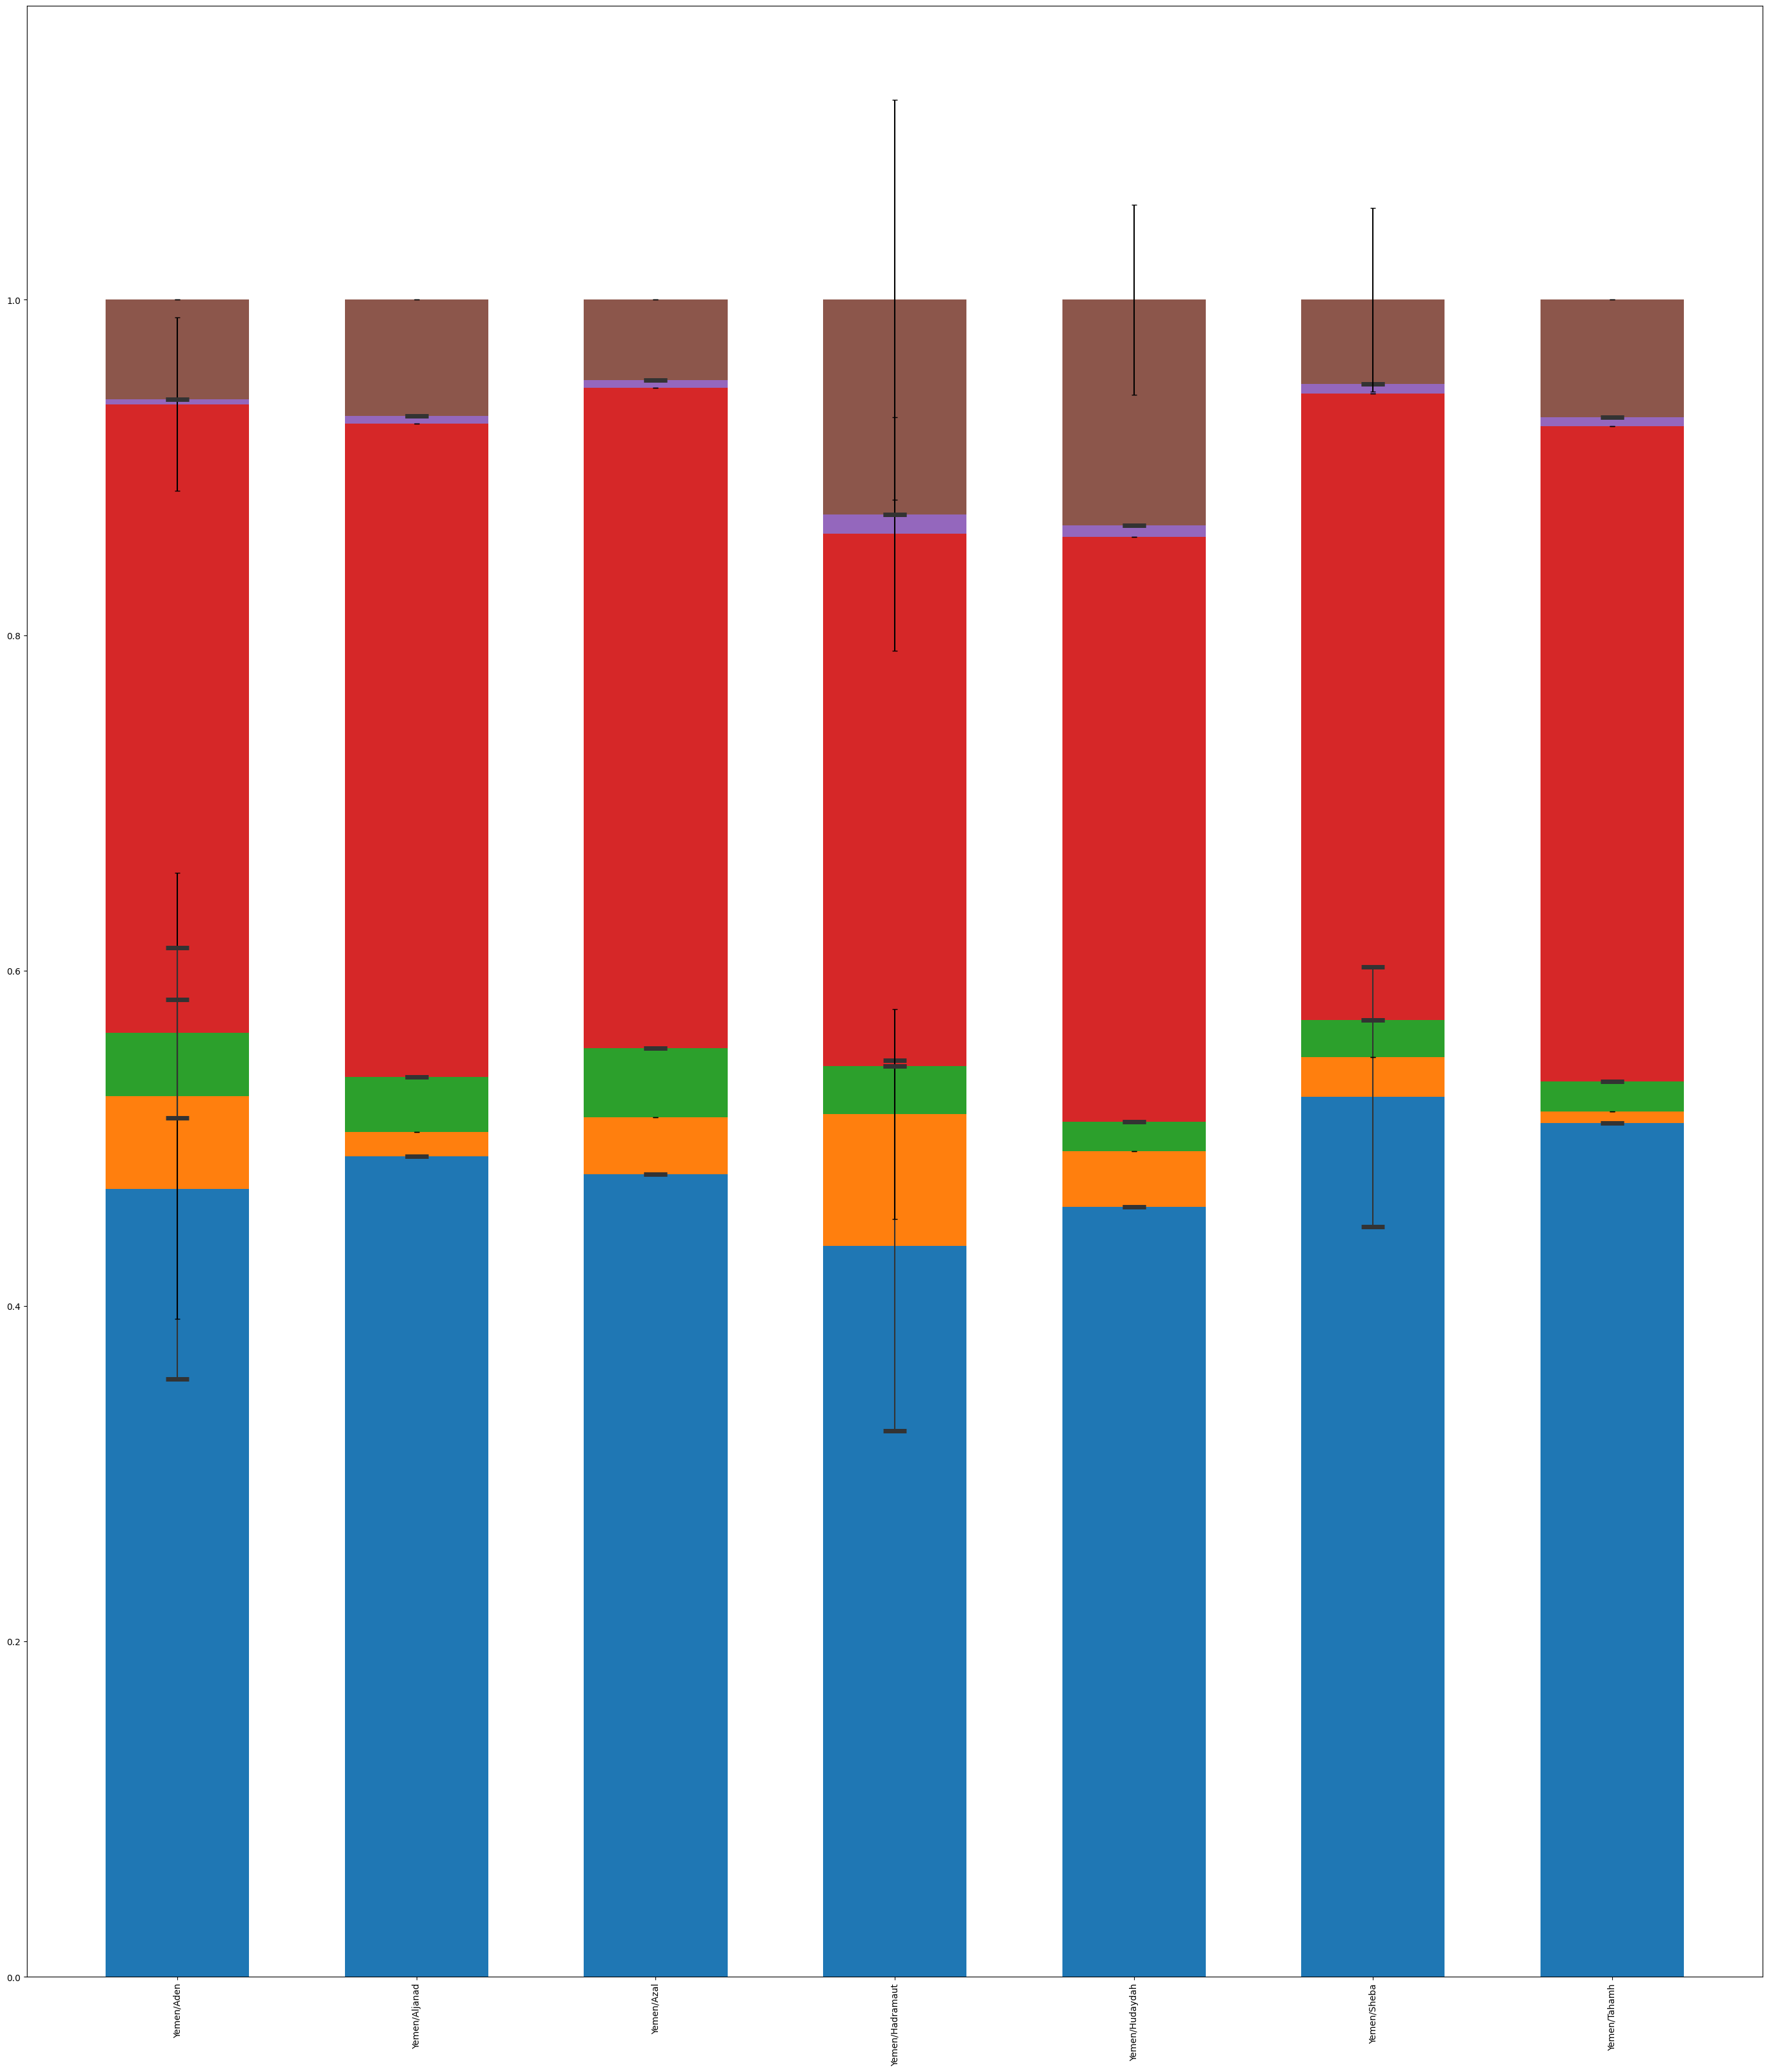

In [11]:
distance=3
k=6
yemenOnly=True
admix =  f"{wdir}/yemen_nearby{distance}K_reichH04.{k}.Q" 
q = pd.read_csv(admix, header=None, sep=' ')
fam = pd.read_csv(f"{wdir}/yemen_nearby{distance}K_reichH04.fam", sep=' ', header=None)
famid = fam[[1]]
famid.columns = ['Id']
qfam = pd.concat([famid, q], axis=1)
qfam = qfam[~qfam.Id.isin(outliers)]
qfam["Pop"] = [lookupPop(row["Id"], meta, districtsCombined=True) for i, row in qfam.iterrows()]
qfam = qfam[qfam.Pop!="Spain"]
qfam = qfam.sort_values(by=['Pop'])
if yemenOnly:
    qfam = qfam[qfam.Pop.str.startswith('Yemen/')] ## Our Yemen samples only



compStd = qfam.groupby('Pop').std()
compStd[compStd < 0.05] = 0 ## don't draw small error bars
compAvg = qfam.groupby('Pop').mean()
pops = np.arange(len(compStd))
for i in range(k):   
    capsize = [13, 3][i%2]
    ecolor = ['0.2', '0.0'][i%2]
    marker = 'sx'[i%2]
    capthick = [5,1][i%2]
    print(marker)
    plt.bar(pops, compAvg[i], yerr=compStd[i], capsize=capsize, error_kw={'capthick': capthick, 'ecolor': ecolor, 'marker':marker}, width=0.6, bottom=compAvg.iloc[:,:i].sum(axis=1))
plt.xticks(pops, compStd.index.values, rotation=90)
plt.savefig(f'admixWerrorbars_k{k}_dist{distance}.svg')

In [34]:
len(qfamSummary)

NameError: name 'qfamSummary' is not defined

In [12]:
qfam.groupby('Pop').mean().iloc[:,:0].sum(axis=1)

Pop
Yemen/Aden         0.0
Yemen/Aljanad      0.0
Yemen/Azal         0.0
Yemen/Hadramaut    0.0
Yemen/Hudaydah     0.0
Yemen/Sheba        0.0
Yemen/Tahamh       0.0
dtype: float64

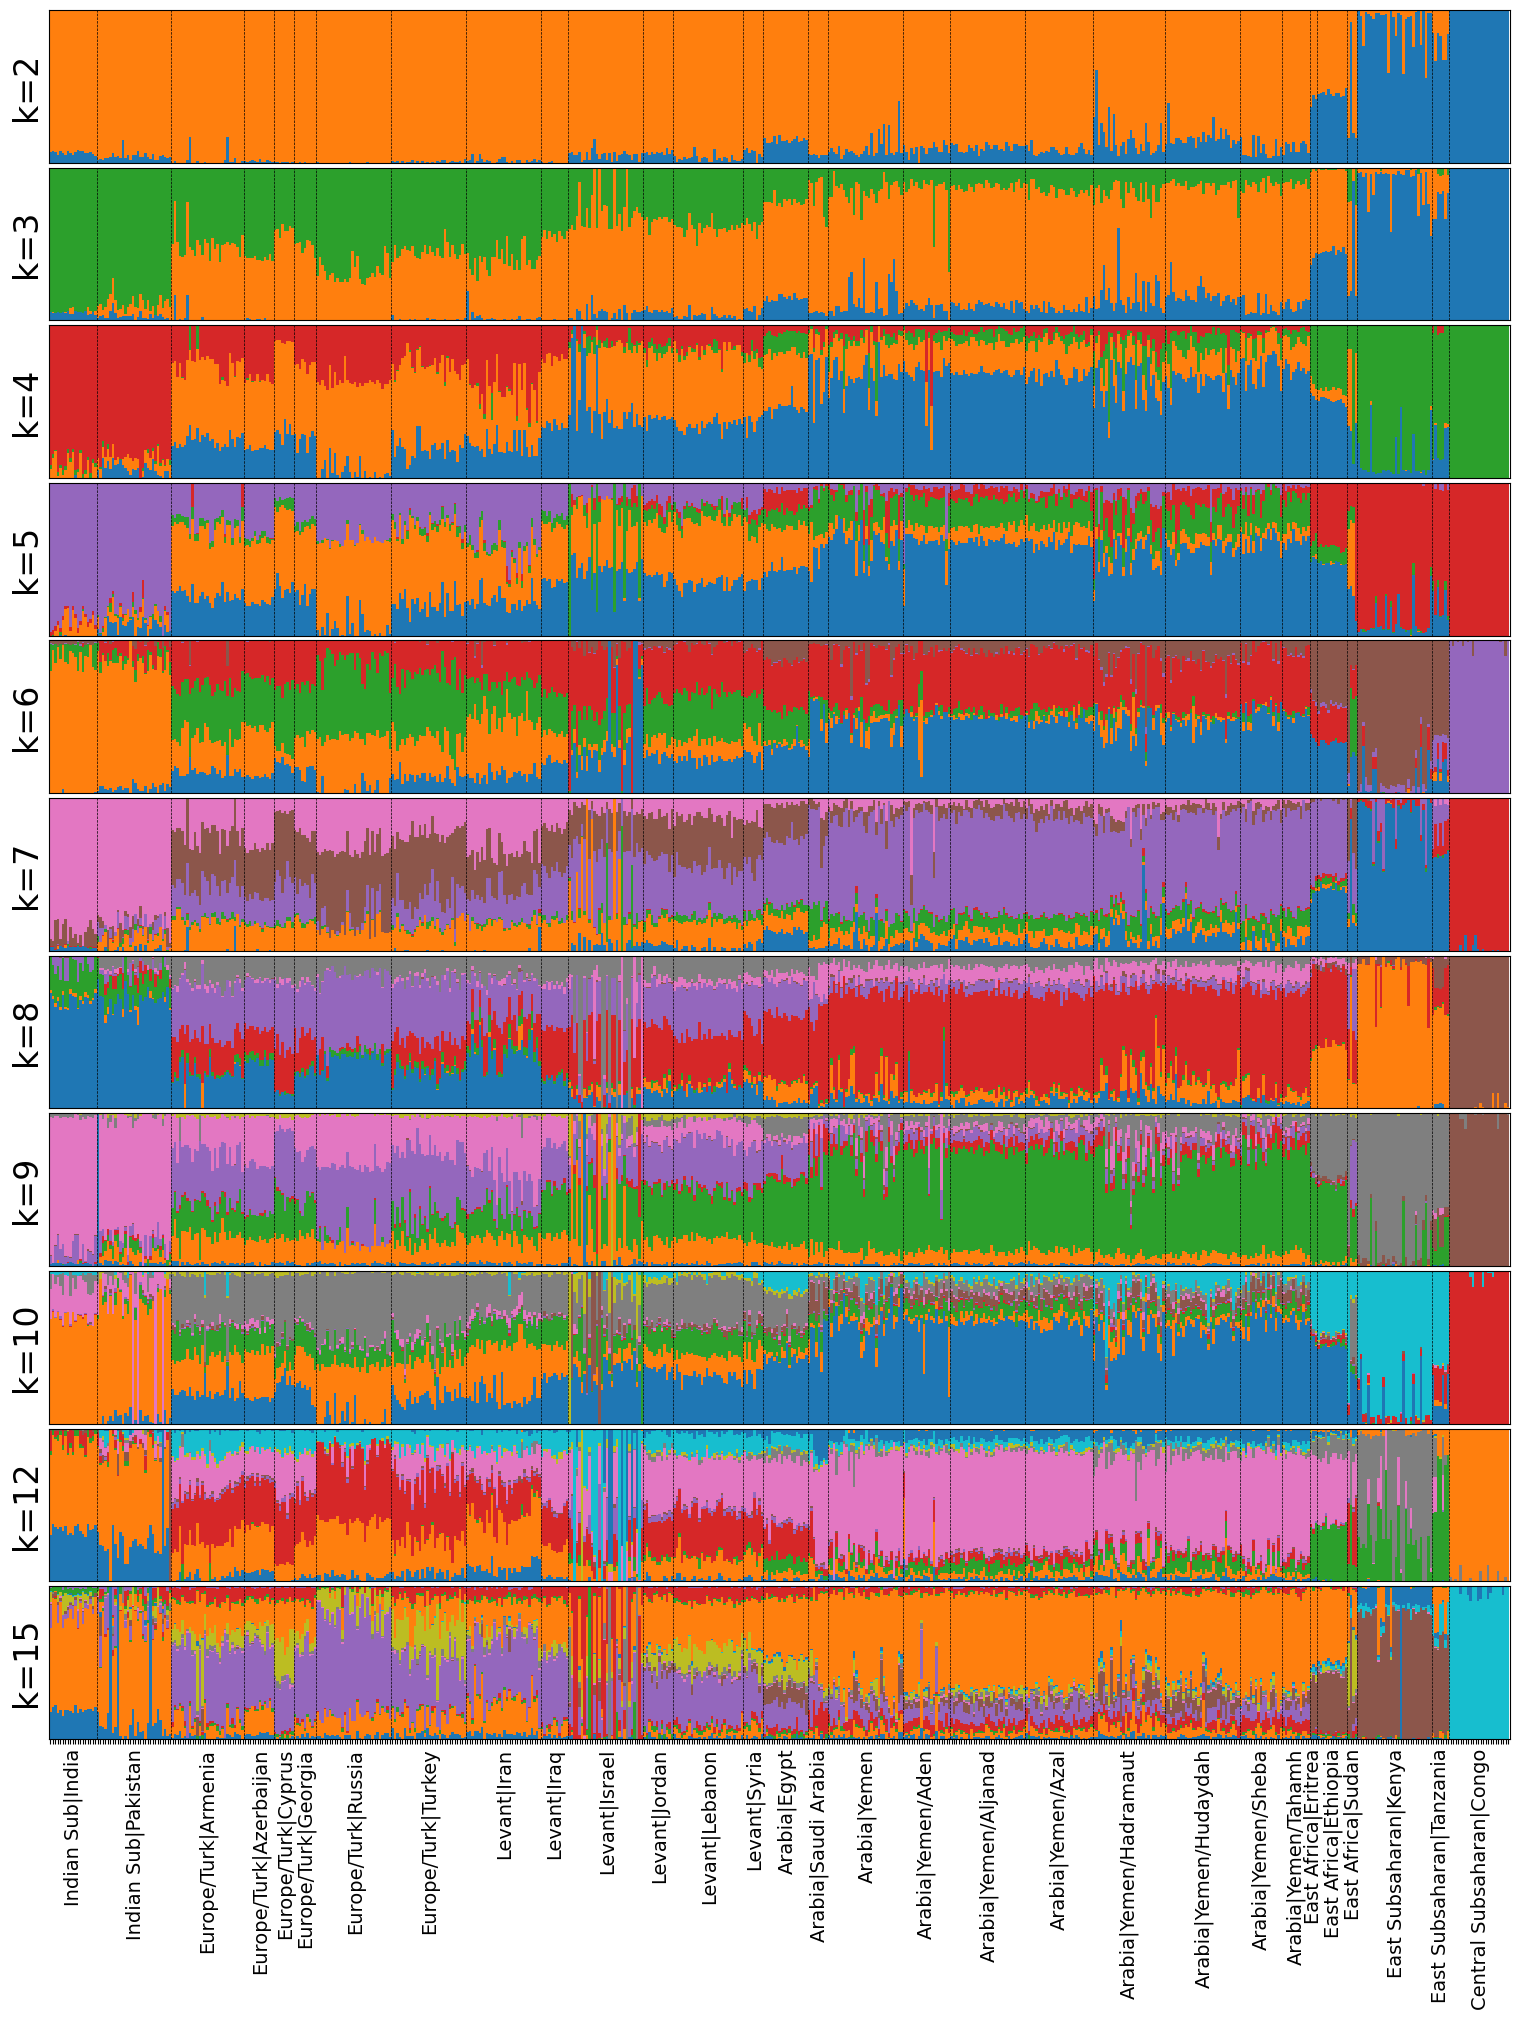

In [30]:
#base = "yemen_nearby1K_reichH04"
grd = {'001 - Europe/Turk': 'Armenia,Russia,Azerbaijan,Cyprus,Georgia,Turkey'.split(','), 
       '002 - Levant': 'Syria,Israel,Jordan,Lebanon,Iraq,Iran'.split(','), 
       '003 - Arabia': 'Egypt,Yemen/Aden,Yemen/Aljanad,Yemen/Azal,Yemen/Hadramaut,Yemen/Hudaydah,Yemen/Sheba,Yemen/Tahamh,Yemen,Saudi Arabia'.split(','), 
       '000 - Indian Sub': 'Pakistan India'.split(), 
       '005 - East Subsaharan': 'Kenya Tanzania'.split(), 
       '006 - Central Subsaharan': ['Congo'],
       '004 - East Africa': 'Sudan Eritrea Ethiopia'.split()}
rgrd = {}
for k,cl in grd.items():
    for c in cl:
        rgrd[c]=k
        

summary = False
yemenOnly = False
plt.rcParams['figure.figsize'] = [15, 20]
plt.rcParams['svg.fonttype'] = 'none'
kRange = [2,3,4,5,6,7,8,9,10,12,15]
for distance in [1,2,3,4,5][2:3]:
    fig, axes = plt.subplots(nrows=len(kRange), ncols=1, sharex=True)
    for counter, k in enumerate(kRange):
        
        admix =  f"{wdir}/yemen_nearby{distance}K_reichH04.{k}.Q" 
        q = pd.read_csv(admix, header=None, sep=' ')
        ## assuming ADMIXTURE did not mess up the order of the plink file
        fam = pd.read_csv(f"{wdir}/yemen_nearby{distance}K_reichH04.fam", sep=' ', header=None)
        famid = fam[[1]]
        famid.columns = ['Id']
        qfam = pd.concat([famid, q], axis=1)
        qfam = qfam[~qfam.Id.isin(outliers)]
        qfam["Pop"] = [lookupPop(row["Id"], meta, districtsCombined=True) for i, row in qfam.iterrows()]        
        if distance<5: qfam = qfam[qfam.Pop!="Spain"]
        qfam['Pop'] = [rgrd[pop]+'|'+pop for pop in qfam.Pop] ## only works for distance=3!!!
        qfam = qfam.sort_values(by=['Pop']) ## could be sorted by additional criteria
        ## downsampling, as some countries dwarf our data
        if not summary:
            qfam = pd.concat([qfam_pop.sample(min(30, len(qfam_pop))) for pop, qfam_pop in qfam.groupby('Pop')])
        label = f"Admixture {k} /{distance*1000}km radius"
        redLabels = reduceLabels(qfam['Pop'])
        barpositions = [i for i,label in enumerate(redLabels) if label]
        qfam[label] = reduceLabels2(qfam['Pop'])
        if summary: ## summarized bar chart, one bar/country or region
            qfamSummary = qfam.groupby('Pop').sum()
            qp = qfamSummary.div(qfamSummary.sum(axis=1), axis=0)
            ax = qp.plot(kind="bar", stacked=True, width=0.8, ax=axes[counter], legend=False)
        else:
            qp = qfam.set_index(label)[q.columns]
            ax = qp.plot(kind="bar", stacked=True, width=1, ax=axes[counter], legend=False)
            ax.axes.yaxis.set_ticks([])
            ax.set_ylabel('k=%s'%k, fontsize=24)   
            
            if k!=kRange[-1]:     
                ax.axes.xaxis.set_visible(False)
                ax.axes.xaxis.set_ticks([])
            else:                
                strippedLabels = [l.split('-')[-1].strip() for l in qfam[label]]
                ax.set_xticklabels(strippedLabels, rotation = 90, fontsize=14) #, position=(0,-0.28))
            ax.set_ylim([0, 1])
            ax.set_xlabel('')
            for barpos in barpositions:
                ax.axvline(barpos-0.5, color='k', linestyle='--', linewidth=0.5)
        
            
    plt.tight_layout(pad=0,h_pad=0,w_pad=0)   
    fig.savefig(f"../Results/admix_Yemen_noOut_{distance}K_3a.pdf")
    fig.savefig(f"../Results/admix_Yemen_noOut_{distance}K_3a.svg")

    #fig.savefig(f"{wdir}/admix_Yemen_noOut_{distance}K_c.svg")
    #plt.show()
    #fig.clf()

In [23]:
strippedLabels

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Indian Sub|India',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Indian Sub|Pakistan',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Europe/Turk|Armenia',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Europe/Turk|Azerbaijan',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Europe/Turk|Cyprus',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Europe/Turk|Georgia',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Europe/Turk|Russia',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Europe/Turk|Turkey',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 

In [41]:
qfam.sort_values('PopGroup Pop'.split())

,Id,0,1,2,3,4,5,Pop,PopGroup
325,KRD_010,0.252311,0.000010,0.386776,0.193769,0.000010,0.167124,Armenia,1
78,EZI-010,0.122615,0.304024,0.325537,0.240705,0.001107,0.006011,Armenia,1
79,EZI-012,0.131453,0.328356,0.297446,0.240117,0.002324,0.000305,Armenia,1
80,EZI-013,0.122315,0.312310,0.324830,0.238284,0.002251,0.000010,Armenia,1
81,EZI-020,0.108942,0.358887,0.331060,0.201090,0.000010,0.000010,Armenia,1
...,...,...,...,...,...,...,...,...,...
1114,HGDP00154.SDG,0.051075,0.826166,0.000010,0.113975,0.005881,0.002894,Pakistan,6
1113,HGDP00201.SDG,0.000010,0.855477,0.112093,0.025130,0.000010,0.007280,Pakistan,6
1112,HGDP00137.SDG,0.050563,0.764133,0.028125,0.138047,0.006676,0.012456,Pakistan,6
1117,HGDP00094.SDG,0.027125,0.819138,0.079186,0.072242,0.002300,0.000010,Pakistan,6


In [157]:
qfamSummary = qfam.groupby('Pop').sum()
qfamSummary = qfamSummary.div(qfamSummary.sum(axis=1), axis=0)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Pop,,,,,,,,,,,,,,,
Abkhazia,0.048609,0.000940,0.000010,0.022083,0.033554,0.011485,0.046949,0.000821,0.035066,0.013996,0.142621,0.003858,0.004275,0.635721,0.000010
Albania,0.314906,0.000187,0.000010,0.003554,0.003211,0.008428,0.050206,0.001462,0.072539,0.005076,0.334426,0.009078,0.002201,0.194705,0.000010
Algeria,0.036526,0.031586,0.001869,0.002424,0.008359,0.015686,0.025460,0.002720,0.110006,0.005685,0.124538,0.550193,0.004740,0.031091,0.049116
Angola,0.000010,0.305994,0.039681,0.002083,0.000010,0.000010,0.000010,0.117833,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.534310
Armenia,0.042669,0.004911,0.000387,0.004512,0.060237,0.021199,0.070653,0.000050,0.152004,0.015617,0.163375,0.020881,0.026657,0.413634,0.003215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yemen/Azal,0.013159,0.028835,0.007131,0.004711,0.024654,0.083069,0.041176,0.002894,0.570707,0.013887,0.058934,0.014179,0.014810,0.117809,0.004046
Yemen/Hadramaut,0.016311,0.059073,0.010153,0.011599,0.029999,0.088943,0.024855,0.014132,0.505891,0.010483,0.037034,0.013238,0.046163,0.089395,0.042730
Yemen/Hudaydah,0.013299,0.086024,0.008286,0.007925,0.026446,0.080711,0.031066,0.008666,0.543924,0.010890,0.040090,0.022336,0.021182,0.075540,0.023614


In [174]:
qfam[]


,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Pop,Admixture 15 Pops/3000km radius
83,EZI-060,0.038404,0.178234,0.017776,0.016385,0.440533,0.000010,0.000554,0.002096,0.038509,0.000010,0.000010,0.150284,0.017306,0.075162,0.024727,Armenia,
325,KRD_010,0.000010,0.000891,0.015602,0.003648,0.000010,0.123923,0.011443,0.028851,0.421378,0.000010,0.034470,0.327884,0.005905,0.022796,0.003179,Armenia,
318,ARM014,0.000010,0.055441,0.031688,0.000010,0.476934,0.000010,0.010309,0.021440,0.079111,0.000010,0.000010,0.198230,0.016581,0.099575,0.010642,Armenia,
316,ARM012,0.005542,0.071384,0.000617,0.036072,0.494737,0.000010,0.003961,0.020751,0.088015,0.000010,0.000010,0.195496,0.009441,0.064226,0.009729,Armenia,
79,EZI-012,0.032604,0.169284,0.024799,0.006764,0.401842,0.000010,0.010390,0.038355,0.074642,0.000687,0.000010,0.165000,0.020786,0.045339,0.009488,Armenia,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,urn:wtsi:402769_E07_3577STDY6068533,0.002928,0.049492,0.019874,0.071298,0.113934,0.016787,0.009015,0.016506,0.032701,0.000010,0.005124,0.620723,0.000010,0.036464,0.005135,Yemen/Tahamh,
1421,urn:wtsi:402769_G04_3577STDY6068502,0.000010,0.029978,0.016855,0.078345,0.128455,0.082162,0.008246,0.001837,0.000010,0.012421,0.011951,0.609204,0.009739,0.009477,0.001308,Yemen/Tahamh,
1398,urn:wtsi:402769_E05_3577STDY6068510,0.005684,0.044709,0.012546,0.077255,0.047736,0.062137,0.018278,0.003799,0.019618,0.012027,0.010382,0.625522,0.006427,0.048161,0.005719,Yemen/Tahamh,
1395,urn:wtsi:402769_E02_3577STDY6068478,0.012039,0.011565,0.000010,0.064046,0.098419,0.068434,0.003856,0.041288,0.004409,0.013949,0.001971,0.625740,0.000010,0.045066,0.009198,Yemen/Tahamh,


In [59]:
reduceLabels2(qfam['Pop'])

['', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Armenia', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Azerbaijan', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Congo', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Cyprus', '', '', '', '', '', '', '', '', '', '', '', '', 'Egypt', '', '', '', '', '', '', '', '', '', 'Eritrea', '', '', '', '', '', '', '', 'Ethiopia', '', '', '', '', '', '', '', '', '', 'Georgia', '', '', '', '', '', '', '', '', '', '', '', '', '', 'India', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Iran', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Iraq', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

In [60]:
qfam.head(50)

,Id,0,1,Pop
325,KRD_010,0.169000,0.831000,Armenia
78,EZI-010,0.017471,0.982529,Armenia
79,EZI-012,0.015179,0.984821,Armenia
80,EZI-013,0.009566,0.990434,Armenia
81,EZI-020,0.004806,0.995194,Armenia
82,EZI-029,0.028019,0.971981,Armenia
83,EZI-060,0.008479,0.991521,Armenia
84,EZI-074,0.009046,0.990954,Armenia
917,S_Armenian-1.DG,0.000010,0.999990,Armenia
924,S_Armenian-2.DG,0.000010,0.999990,Armenia


## Cross validation

In [34]:
qfam[qfam]

,Id,0,1,2,3,4,5,Pop,Admixture 6 Pops/1000km radius
28,Eritrean_2,0.226374,0.018716,0.701702,0.035822,0.000010,0.017378,Eritrea,Eritrea
29,Eritrean_3,0.029141,0.035528,0.846918,0.064974,0.022345,0.001094,Eritrea,
27,Eritrean_1,0.105742,0.018956,0.861386,0.000010,0.000010,0.013896,Eritrea,
0,EAF4646,0.061129,0.013954,0.867332,0.030513,0.002831,0.024241,Ethiopia,Ethiopia
1,EAF4648,0.000010,0.000010,0.998595,0.000010,0.000010,0.001365,Ethiopia,
...,...,...,...,...,...,...,...,...,...
204,urn:wtsi:402769_A12_3577STDY6068626,0.698361,0.013212,0.140395,0.102591,0.009725,0.035716,Yemen - Tiz,
202,urn:wtsi:402769_A10_3577STDY6068571,0.664039,0.046303,0.154124,0.077770,0.023155,0.034608,Yemen - Tiz,
288,urn:wtsi:402769_H12_3577STDY6068642,0.706151,0.027358,0.151242,0.068902,0.021675,0.024672,Yemen - Tiz,
275,urn:wtsi:402769_G11_3577STDY6068620,0.676129,0.047383,0.161082,0.077495,0.016819,0.021091,Yemen - Tiz,


In [ ]:
#grep '^CV error' log_nearby2_*.out > cv2K.txt

In [69]:
line="log_nearby2_10.out:CV error (K=10): 0.66469\n"
def processLine(line):
    fields = line.strip().split()
    cv = float(fields[-1])
    k = int(fields[-2][3:-2])
    return k,cv

In [70]:
!ls -l $wdir

total 903584
-rw-rw-r-- 1 ahenschel ahenschel    95458 May 31 11:04 admixPlot_yemen_1K.pdf
-rw-rw-r-- 1 ahenschel ahenschel   706787 May 31 11:04 admix_Yemen_1K.pdf
-rw-rw-r-- 1 ahenschel ahenschel  1388440 May 31 11:04 admix_Yemen_2K.pdf
-rw-rw-r-- 1 ahenschel ahenschel  3248999 May 31 11:04 admix_Yemen_3K.pdf
-rw-rw-r-- 1 ahenschel ahenschel  4773615 May 31 11:04 admix_Yemen_4K.pdf
-rw-rw-r-- 1 ahenschel ahenschel  6453567 May 31 11:04 admix_Yemen_5K.pdf
-rw-rw-r-- 1 ahenschel ahenschel  3539069 Jul  2 19:38 admix_Yemen_noOut_1K_b.svg
-rw-rw-r-- 1 ahenschel ahenschel   691610 May 31 11:04 admix_Yemen_noOut_1K.pdf
-rw-rw-r-- 1 ahenschel ahenschel  5733447 May 31 11:04 admix_Yemen_noOut_1K.svg
-rw-rw-r-- 1 ahenschel ahenschel  4485878 Jul  2 19:38 admix_Yemen_noOut_2K_b.svg
-rw-rw-r-- 1 ahenschel ahenschel   938331 May 31 11:04 admix_Yemen_noOut_2K.pdf
-rw-rw-r-- 1 ahenschel ahenschel  8639557 May 31 11:04 admix_Yemen_noOut_2K.svg
-rw-rw-r-- 1 ahenschel ahenschel  2861179 Jun 30 12:05 

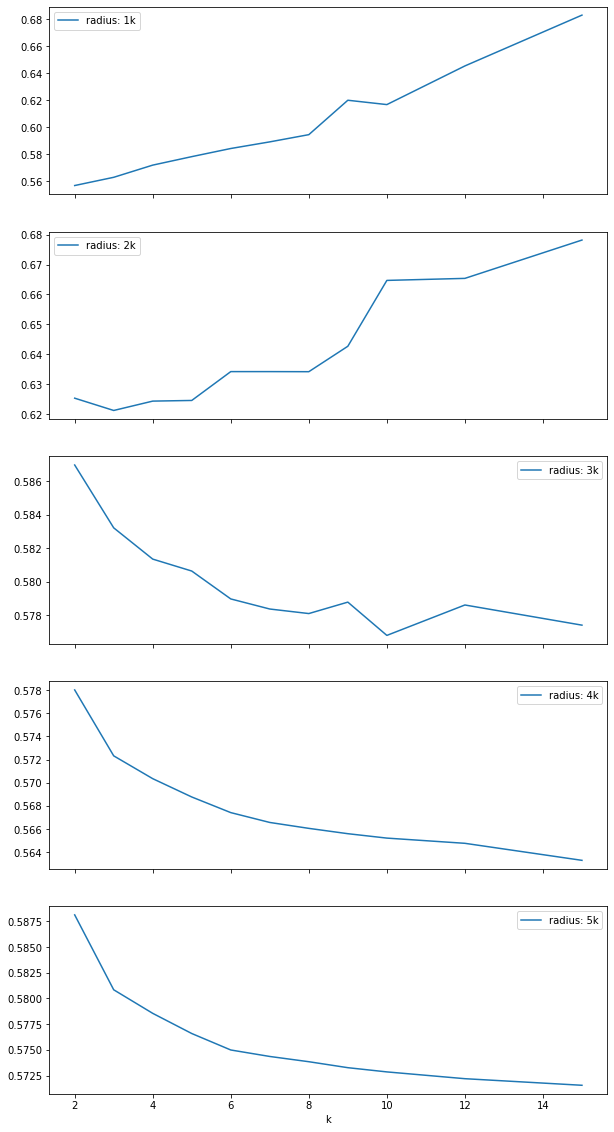

In [71]:
import numpy as np
plt.rcParams['figure.figsize'] = [10, 20]

fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True)
for d in range(5):
    df = pd.DataFrame(sorted([processLine(line) for line in open(f"{wdir}/cv{d+1}K.txt")]), columns=['k','cve'])
    df = df.set_index('k')
    df.plot(kind='line', ax=axes[d])
    axes[d].legend([f'radius: {d+1}k'])
fig.savefig(f"{wdir}/admix_Yemen_noOut_cvAll3.svg")

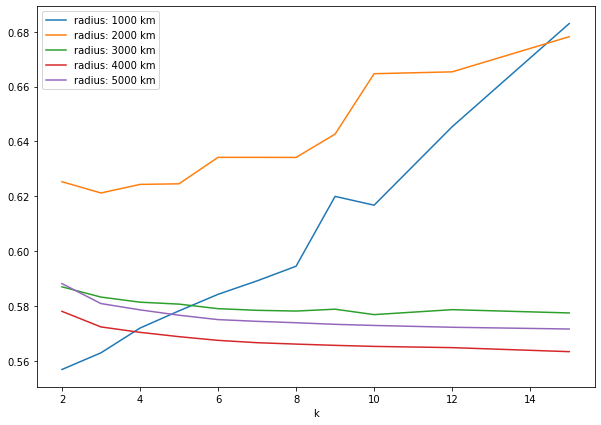

In [77]:

plt.rcParams['figure.figsize'] = [10, 7]
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)
for d in range(5):
    df = pd.DataFrame(sorted([processLine(line) for line in open(f"{wdir}/cv{d+1}K.txt")]), columns=['k','cve'])
    df = df.set_index('k')
    df.plot(kind='line', ax=axes)
axes.legend([f'radius: {d+1}000 km' for d in range(5)])
#fig.suptitle('Cross validation for increasing regional contexts')
fig.savefig(f"../Results/admix_Yemen_noOut_cvAll2.pdf")

In [73]:
wdir

'../Admixture/Regional'